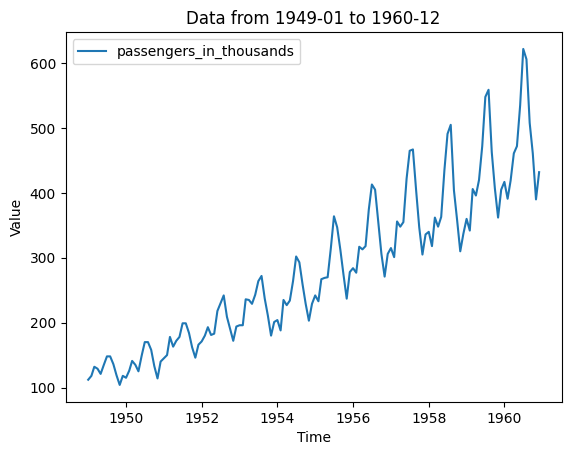

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/airline/airline.csv')

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path,parse_dates=['Month'],  index_col=['Month'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/airline/airline.csv', '1949-01', '1960-12')

In [4]:
import pandas as pd
import torch

from torch.utils.data import DataLoader
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster
from src.scaler import Scaler
from src.utils import EarlyStopper

from src.train import train, inference

t = 12
hs = 128
n = 1
nEpochs = 20000
lr = 1e-5
batchSize = 48

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('No CUDA GPU detected. Using CPU instead.')

datasetPath = 'data/airline'
input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
field_to_be_scaled = list(set(input_field+output_field))

train_df = pd.read_csv(datasetPath+'/train.csv')
val_df = pd.read_csv(datasetPath+'/val.csv')
test_df = pd.read_csv(datasetPath+'/test.csv')       

scaler = Scaler(train_df[field_to_be_scaled], 'minmax')

train_dataset = TimeSeriesDataset(train_df, input_field, output_field, t=t, scaler=scaler)
val_dataset = TimeSeriesDataset(val_df, input_field, output_field, t=t, scaler=scaler)
test_dataset = TimeSeriesDataset(test_df, input_field, output_field, t=t, scaler=scaler)

model = LSTMForecaster(input_size=len(input_field), 
                       output_size=len(output_field),
                       hidden_size=hs,
                        num_layers=n)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
criterion = torch.nn.L1Loss()
startEpoch = 0
early_stopper = EarlyStopper(patience=10, delta=0)

print('------------------------------- Training -------------------------------')
for epoch in range(startEpoch+1, nEpochs+1):
    epoch_train_loss = train(train_dataset, model, criterion, optimizer, device, batchSize)
    epoch_val_loss = inference(val_dataset, model, criterion, device, batchSize)

    print('Epoch {} completed: \nTrain loss: {:.6f} \nValidation loss: {:.6f}'.format(
    epoch, epoch_train_loss, epoch_val_loss), flush = True)
    early_stopper(epoch_val_loss)
    if early_stopper.early_stop:
        print('Early stopping')
        break

No CUDA GPU detected. Using CPU instead.
------------------------------- Training -------------------------------
Epoch 1 completed: 
Train loss: 0.398005 
Validation loss: 0.924219
Epoch 2 completed: 
Train loss: 0.402278 
Validation loss: 0.923666
Epoch 3 completed: 
Train loss: 0.400680 
Validation loss: 0.923107
Epoch 4 completed: 
Train loss: 0.401590 
Validation loss: 0.922536
Epoch 5 completed: 
Train loss: 0.399217 
Validation loss: 0.921951
Epoch 6 completed: 
Train loss: 0.401643 
Validation loss: 0.921353
Epoch 7 completed: 
Train loss: 0.396154 
Validation loss: 0.920739
Epoch 8 completed: 
Train loss: 0.398180 
Validation loss: 0.920112
Epoch 9 completed: 
Train loss: 0.396763 
Validation loss: 0.919471
Epoch 10 completed: 
Train loss: 0.395938 
Validation loss: 0.918816
Epoch 11 completed: 
Train loss: 0.394582 
Validation loss: 0.918148
Epoch 12 completed: 
Train loss: 0.398346 
Validation loss: 0.917468
Epoch 13 completed: 
Train loss: 0.395819 
Validation loss: 0.91677

KeyboardInterrupt: 

In [8]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_strategy import LSTMStrategy
from src.train import train, inference

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
timeseries_field = list(set(input_field + output_field))
datasetPath = 'data/airline/airline.csv'
modelPath = 'out/LSTMForecaster_airline/n1_hs4_t18/best.pth.tar'

n=1
hs=4
t=18

strategy = LSTMStrategy(modelPath, num_layers=n, hidden_size=hs, lookback_length=t)
strategy.load_data(datasetPath)
df = strategy.forecast(input_field, output_field, 12)

=> loaded checkpoint 'True' (epoch 34568)
Checkpoint's train loss is: 0.1299
Checkpoint's validation loss is: 0.0047


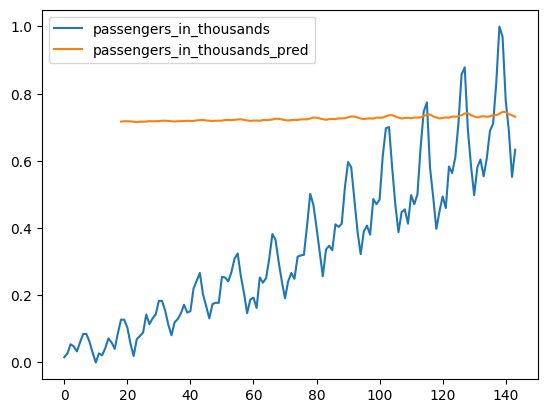

In [9]:
import matplotlib.pyplot as plt

cols = ['passengers_in_thousands', 'passengers_in_thousands_pred']
for col in cols:
    plt.plot(df[col], label=col)
plt.legend()
plt.show()